# Sparse Bottleneck Networks for Exploratory Analysisand Visualization of Neural Patch-seq Data

In [1]:
# Import packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib
import seaborn as sns
import sparseRRR
import matplotlib
import matplotlib.pyplot as plt
import importlib

import bottleneck_networks

import time
import pickle
import warnings

dtype = tf.float32

# Loading data

For pre-processing (gene selection, delete ephys-rna mismatches, delete low rna quality cells, ...) of the raw data check BottleneckNN_preprocessing.

In [2]:
M1_ephys = pd.read_csv('data/ephys_values.csv', index_col=0)
rpkm = pd.read_csv('data/gene_counts.csv', index_col='gene')
geneNames = np.array(list(rpkm.index))

In [3]:
# Now specify for all the cells left what the cell type is (according to transcriptomic mappings)
prop = pd.read_csv('data/mini-atlas-meta-data.csv', sep = '\t')
prop = prop.rename(columns = {'Sample': 'sample_id', 'Targeted layer': 'Layer'})
prop = prop[['Cell', 'RNA type', 'sample_id', 'Layer', 'Cre', 'RNA type top-3']]
sample_name = ['{}{}{}'.format(g.split('_')[0], g.split('_')[1], g.split('_')[2]) for g in prop['Cell']]
prop['sample name'] = sample_name
prop = prop.set_index('sample name')

prop = prop.reindex(M1_ephys.index) # There could be more cells with ephys than manually labelled
                                    # They will receive the Nan property
prop = prop.fillna('')
M1_Allen_Mapping = prop['RNA type']
M1_Allen_Mapping[np.where(M1_Allen_Mapping == '')[0]] = 'low quality'
number_labels = {c: i for i, c in enumerate(np.unique(M1_Allen_Mapping))}
cellTypes = np.array([number_labels[cell_type] for cell_type in M1_Allen_Mapping])

In [58]:
print('Double check:\n')
print('RPKM shape: ', rpkm.shape)
print('ephys shape: ', M1_ephys.shape)
print('cellTypes shape: ', cellTypes.shape)

Double check:

RPKM shape:  (1000, 1213)
ephys shape:  (1213, 16)
cellTypes shape:  (1213,)


In [59]:
cellTypeColors = {'Lamp5 Pax6': '#DDACC9', 'Lamp5 Egln3_1': '#FF88AD', 'Lamp5 Egln3_2': '#DD8091', 'Lamp5 Egln3_3': '#F08E98',
 'Lamp5 Pdlim5_1': '#FF7290', 'Lamp5 Pdlim5_2': '#FF8C97', 'Lamp5 Slc35d3': '#FFA388', 'Lamp5 Lhx6': '#C77963',
 'Sncg Col14a1': '#7E0ACB', 'Sncg Slc17a8': '#9440F3', 'Sncg Calb1_1': '#9611B6', 'Sncg Calb1_2': '#9900B3',
 'Sncg Npy2r': '#7A0099', 'Vip Sncg': '#AA4DB5', 'Vip Serpinf1_1': '#A720FF', 'Vip Serpinf1_2': '#AB1DFF',
 'Vip Serpinf1_3': '#FF5FCD', 'Vip Htr1f': '#FF4DC1', 'Vip Gpc3': '#B09FFF', 'Vip C1ql1': '#BD3D9A',
 'Vip Mybpc1_1': '#F70CF3', 'Vip Mybpc1_2': '#992E81', 'Vip Mybpc1_3': '#AB379C', 'Vip Chat_1': '#FF00FF',
 'Vip Chat_2': '#B3128A', 'Vip Igfbp6_1': '#7779BF', 'Vip Igfbp6_2': '#626EB8', 'Sst Chodl': '#FFFF00',
 'Sst Penk': '#FF8011', 'Sst Myh8_1': '#FF9F2C', 'Sst Myh8_2': '#FFB307', 'Sst Myh8_3': '#FFBF09',
 'Sst Htr1a': '#BFAF00', 'Sst Etv1': '#FFB22B', 'Sst Pvalb Etv1': '#D9C566', 'Sst Crhr2_1': '#BE8652',
 'Sst Crhr2_2': '#B0993C', 'Sst Hpse': '#CDB115', 'Sst Calb2': '#D2A328', 'Sst Pvalb Calb2': '#784F14',
 'Sst Pappa': '#635821', 'Sst C1ql3_1': '#802600', 'Sst C1ql3_2': '#8A2B1A', 'Sst Tac2': '#804600',
 'Sst Th_1': '#8C6012', 'Sst Th_2': '#A81111', 'Sst Th_3': '#9B211B', 'Pvalb Gabrg1': '#ED4C50',
 'Pvalb Egfem1': '#C05661', 'Pvalb Gpr149': '#E62A5D', 'Pvalb Kank4': '#BC4B11', 'Pvalb Calb1_1': '#B6411E',
 'Pvalb Calb1_2': '#BC2D71', 'Pvalb Reln': '#9C4165', 'Pvalb Il1rapl2': '#BC2C41', 'Pvalb Vipr2_1': '#FF197F',
 'Pvalb Vipr2_2': '#F4358B', 'L2/3 IT_1': '#00FF34', 'L2/3 IT_2': '#07D945', 'L2/3 IT_3': '#2EB934',
 'L4/5 IT_1': '#09CCC6', 'L4/5 IT_2': '#52B8AA', 'L5 IT_1': '#58D2C1', 'L5 IT_2': '#4A9F93', 'L5 IT_3': '#4EAC9C',
 'L5 IT_4': '#52B4B8', 'L6 IT_1': '#B2AD23', 'L6 IT_2': '#81791F', 'L6 IT Car3': '#5100FF', 'L5 PT_1': '#0D5D7E',
 'L5 PT_2': '#0B77A5', 'L5 PT_3': '#0B8AA5', 'L5 PT_4': '#0A75B1', 'L5/6 NP_1': '#48CB80', 'L5/6 NP_2': '#3C78BC',
 'L5/6 NP_3': '#47867A', 'L5/6 NP CT': '#1AAB99', 'L6 CT Gpr139': '#168577', 'L6 CT Cpa6': '#338C5E', 'L6 CT Grp': '#2FBCE5',
 'L6 CT Pou3f2': '#3E766C', 'L6 CT Kit_1': '#516B78', 'L6 CT Kit_2': '#557361', 'L6b Col6a1': '#69419D',
 'L6b Shisa6_1': '#46306A', 'L6b Shisa6_2': '#464576', 'L6b Ror1': '#7044AA', 'L6b Kcnip1': '#573D90'}

# Normalization of data

In [60]:
# Preprocess subset of the data in a systematic manner (library normalization and Z-scoring)
geneNames = np.array(list(rpkm.index))
Y = M1_ephys.values
X = rpkm.values.astype(np.float).T
X = X / np.sum(X, axis=1, keepdims=True) * \
                np.median(np.sum(X, axis=1, keepdims=True))

# Log-transform
X = np.log2(X + 1)

# Sort out cells with nans in the transcriptomic data
ind_non_nan = ~np.isnan(np.sum(X, axis=1))
X = X[ind_non_nan, :]
Y = Y[ind_non_nan, :]
cellTypes = cellTypes[ind_non_nan]

# Standardize Y
mu = np.mean(Y, axis=0)
Y = Y - mu
sigma = np.std(Y, axis=0)
Y = Y / sigma

# Standardize X
mu = np.mean(X, axis=0)
X = X - mu
sigma = np.std(X, axis=0)
X = X / sigma

X_no_low_qual = X.astype('float32')
Y_no_low_qual = Y.astype('float32')

In [61]:
cellTypeLabels = {i: c for i, c in enumerate(np.unique(M1_Allen_Mapping))}
amount_of_cells = {cell_type: sum(M1_Allen_Mapping==cell_type) for cell_type in np.unique(M1_Allen_Mapping)}
for_every_cell_number_of_cells_of_their_celltype = np.array([amount_of_cells[cellTypeLabels[c]] for c in cellTypes])
ind_pre_training = for_every_cell_number_of_cells_of_their_celltype >= 10

Let us find K-mean clusters to perform pre-training. One could also pre-train on celltype classification. This has actually improved performance even more but could be argued to be biasing the results too much. K-means allows for an unsupervised more general setting.

In [66]:
# You can cluster according to amounts of classes or amounts of celltypes. Change the argument of n_clusters accordingly.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=17, n_init=1000).fit(Y_no_low_qual)

In [67]:
clusters = kmeans.labels_

In [68]:
amount_of_cells_in_clusters = {cluster_id: sum(clusters==cluster_id) for cluster_id in np.unique(clusters)}
for_every_cell_number_of_cells_of_their_cluster = np.array([amount_of_cells_in_clusters[cell] for cell in clusters])
ind_pre_training_clusters = for_every_cell_number_of_cells_of_their_cluster >= 10

In [69]:
# So that we have other colours too that distinguish well among each other (for the clusters)
clusterCols = ["#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
       "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
       "#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
       "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
       "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
       "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
       "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
       "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
       "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
       "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
       "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
       "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
       "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
       "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
       "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
       "#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58"]

# Keras initialisations

In [70]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics

In [71]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

In [72]:
def r2_score(y_truth, y_pred):
    residual = tf.add(y_truth, -y_pred, name='residual')
    return 1-tf.reduce_sum(tf.square(residual)) / tf.reduce_sum(tf.square(y_truth))

In [73]:
class ElasticNet(tf.keras.regularizers.Regularizer): 
    def __init__(self, l1=1e-8, l2=1.0): 
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x): 
        return self.l2*tf.math.reduce_sum(tf.math.square(x)) + \
                             self.l1*tf.reduce_sum(tf.norm(x, ord = 2, axis = 1))

    def get_config(self): 
        return {'l1': float(self.l1), 'l2': float(self.l2)}

# Running models and comparative analysis

First we train the lasso 1e-1 freeze (4 last layers) unfreeze model for the entire dataset.

In [74]:
importlib.reload(bottleneck_networks)

<module 'bottleneck_networks' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/bottleneck_revision/bottleneck_networks.py'>

In [75]:
from bottleneck_networks import ClassificationPreTrain

In [76]:
cvfold_id=3000 # Random integer number given by you to save files (We used 1000 to construct the one for the paper)

l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
nodes_list=[512,128,2,128,512]

t = time.time()
np.random.seed(seed)
n = X_no_low_qual.shape[0]
X = np.copy(X_no_low_qual)
Y = np.copy(Y_no_low_qual)
clusters_ = np.copy(clusters)

CE_loss = np.zeros((l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((l1_params.shape[0], l2_params.shape[0], epochs))


pre_train_size = 0.6
train_cnt = round(X.shape[0]*pre_train_size)
x_train_pre_tr_ = X[:train_cnt, :]
x_test_pre_tr_ = X[train_cnt:, :]
clusters_train_pre_tr_ = clusters_[:train_cnt]
clusters_test_pre_tr_ = clusters_[train_cnt:]

for i, l2 in enumerate(l2_params):
    #print('Ridge penalty: ', l2)
    for j, l1 in enumerate(l1_params):
        #print('Lasso penalty: ', l1)


        input_dim = x_train_pre_tr_.shape[1]
        output_dim = to_categorical(clusters_train_pre_tr_).shape[1]
        BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                   output_dim=output_dim, nodes_list=nodes_list)
        CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                           cluster_train=clusters_train_pre_tr_, \
                                                                           x_test=x_test_pre_tr_, \
                                                                           cluster_test=clusters_test_pre_tr_, \
                                                                           epochs=epochs, bs=bs, patience=patience, \
                                                                           cvfold_id=cvfold_id, l1_id=j, l2_id=i, \
                                                                           verbose=0)
        CE_loss[j, i] = CE_test
        CE_loss_tr[j, i] = CE_train
        pre_tr_hist[j, i] = test_hist
        pre_tr_hist_tr[j, i] = train_hist
        #print('Test CE loss (pre-training): ', CE_loss[j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

[INFO] training network...
485/485 [==============================] - 0s 89us/sample - loss: 2.3443 - categorical_crossentropy: 2.2619
[INFO] training network...
485/485 [==============================] - 0s 85us/sample - loss: 9.1600 - categorical_crossentropy: 2.0804
[INFO] training network...
485/485 [==============================] - 0s 98us/sample - loss: 49.5496 - categorical_crossentropy: 2.2648
[INFO] training network...
485/485 [==============================] - 0s 86us/sample - loss: 119.3368 - categorical_crossentropy: 2.2000
Time: 0.0h  0m 42s


In [84]:
from bottleneck_networks import FreezeUnfreeze

In [85]:
cvfold_id=3000 # Random integer number given by you to save files (We used 1000 to construct the one for the paper)

l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first
prune=True
nodes_list=[512,128,2,128,512]

r2_freeze_unfreeze_hist_tr=np.zeros((l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_freeze_unfreeze_hist_tr_AE=np.zeros((l1_params.shape[0], l2_params.shape[0], 2*epochs)) 

t = time.time()
np.random.seed(seed)
n = X_no_low_qual.shape[0]
X = np.copy(X_no_low_qual)
Y = np.copy(Y_no_low_qual)

    
input_dim = X.shape[1]
output_dim = Y.shape[1]

for i, l2 in enumerate(l2_params):
    print('Ridge penalty: ', l2)
    for j, l1 in enumerate(l1_params):
        print('Lasso penalty: ', l1)

        pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold_id, j, i)
        input_dim = X.shape[1]
        output_dim = Y.shape[1]
        BN_PreTrFreezeUnfreeze=FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                   unfreeze = unfreeze, \
                                                   pre_trained_weights=pre_trained_weights, \
                                                   pre_trained_weights_h5=pre_trained_weights_h5, \
                                                   nodes_list=nodes_list)
        train_hist, AE_hist=BN_PreTrFreezeUnfreeze.train_full_dataset(x_train=X, y_train=Y, \
                                                                epochs=epochs, bs=bs, patience=patience, \
                                                                cvfold_id=cvfold_id, l1_id=j, l2_id=i, \
                                                                prune=prune, geneNames=geneNames, \
                                                                verbose=0, add_autoencoder=True)
        r2_freeze_unfreeze_hist_tr[j, i]=train_hist
        r2_freeze_unfreeze_hist_tr_AE[j, i]=AE_hist
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

Ridge penalty:  1e-10
Lasso penalty:  0.0001
[INFO] training network...
[INFO] training ephys prediction network...
The 25 genes that make it:  ['Cdh13' 'Vwa5b1' 'Ndnf' 'Gm47283' 'Tcp1' 'Cntnap5c' 'Arhgap32' 'Gm15261'
 'Gad1' 'Oxr1' 'Sla' 'Cplx3' 'Bcl2l11' 'Actr1b' 'Rprm' 'Mpped1' 'Col6a1'
 'AI597479' 'Grip1' 'Tiam2' 'Itgam' 'Htatsf1' 'Psmd2' 'Pvalb' 'Ptk2b']
[INFO] training pruning network...
[INFO] training autoencoder network
Lasso penalty:  0.01
[INFO] training network...
[INFO] training ephys prediction network...
The 25 genes that make it:  ['Enpp2' 'Rnf112' 'Prox1' 'Pamr1' 'Gm49948' 'Ptprk' 'Tac2' 'Col19a1'
 'Pcp4l1' 'Synpr' 'Tafa1' 'Erbb4' 'Sparcl1' 'Adarb2' 'Crh' 'Rit2' 'Egfr'
 'Ndn' 'Dlx6os1' 'Sst' 'Adcyap1' 'Lamp5' 'Pvalb' 'Gad1' 'Vip']
[INFO] training pruning network...
[INFO] training autoencoder network
Lasso penalty:  0.1
[INFO] training network...
[INFO] training ephys prediction network...
The 25 genes that make it:  ['Cacna1e' 'Mybpc1' 'Elmo1' 'Rab3b' 'Parm1' 'Sema5a'

In [90]:
r2_freeze_unfreeze_hist_tr_Full_Dataset=r2_freeze_unfreeze_hist_tr
r2_freeze_unfreeze_hist_tr_Full_Dataset_AE=r2_freeze_unfreeze_hist_tr_AE

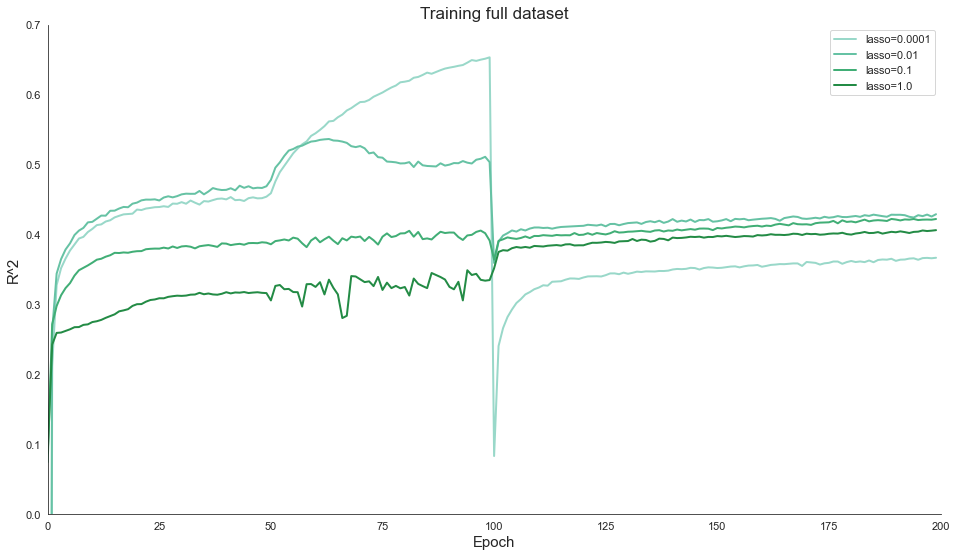

In [91]:
# The learning curves for our favourite model: pre-tr + train last 4 layers only + train all + prune
linewidth = 2

epochs_used = 200
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']
for j, l1 in enumerate(l1_params):
    ax.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr_Full_Dataset, axis = (1))[j,:], \
             c = colours[j], linewidth=linewidth, label='lasso={}'.format(l1))
ax.set_ylim([0, 0.7])
ax.set_xlim([0, 200])
ax.set_title('Training full dataset', fontsize = 17)
ax.set_xlabel('Epoch', fontsize = 15)
ax.set_ylabel('R^2', fontsize = 15)
ax.legend(loc='best', fontsize = 11)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)
sns.despine()

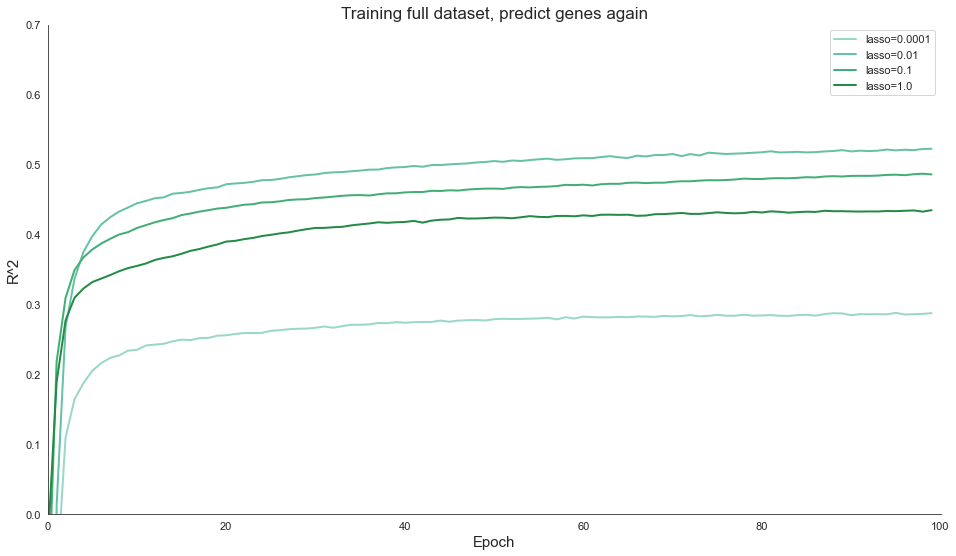

In [92]:
# The learning curves for our favourite model: pre-tr + train last 4 layers only + train all + prune + predict genes again
# i.e. autoencoding decoder
linewidth = 2
epochs_used = 100
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']
for j, l1 in enumerate(l1_params):
    ax.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr_Full_Dataset_AE, axis = (1))[j,:], \
             c = colours[j], linewidth=linewidth, label='lasso={}'.format(l1))
ax.set_ylim([0, 0.7])
ax.set_xlim([0, 100])
ax.set_title('Training full dataset, predict genes again', fontsize = 17)
ax.set_xlabel('Epoch', fontsize = 15)
ax.set_ylabel('R^2', fontsize = 15)
ax.legend(loc='best', fontsize = 11)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)
sns.despine()

We rerun the same model an additional 9 times to see how many times we select same genes etc.

In [93]:
from bottleneck_networks import ClassificationPreTrain

In [94]:
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
nodes_list=[512,128,2,128,512]

t = time.time()
np.random.seed(seed)
n = X_no_low_qual.shape[0]
X = np.copy(X_no_low_qual)
Y = np.copy(Y_no_low_qual)
clusters_ = np.copy(clusters)

CE_loss = np.zeros((l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((l1_params.shape[0], l2_params.shape[0], epochs))


pre_train_size = 0.6
train_cnt = round(X.shape[0]*pre_train_size)
x_train_pre_tr_ = X[:train_cnt, :]
x_test_pre_tr_ = X[train_cnt:, :]
clusters_train_pre_tr_ = clusters_[:train_cnt]
clusters_test_pre_tr_ = clusters_[train_cnt:]

for f in range(0,9):
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)


            input_dim = x_train_pre_tr_.shape[1]
            output_dim = to_categorical(clusters_train_pre_tr_).shape[1]
            BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                       output_dim=output_dim, nodes_list=nodes_list)
            CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                               cluster_train=clusters_train_pre_tr_, \
                                                                               x_test=x_test_pre_tr_, \
                                                                               cluster_test=clusters_test_pre_tr_, \
                                                                               epochs=epochs, bs=bs, patience=patience, \
                                                                               cvfold_id=cvfold_id+1+f, l1_id=j, l2_id=i, \
                                                                               verbose=0)
            CE_loss[j, i] = CE_test
            CE_loss_tr[j, i] = CE_train
            pre_tr_hist[j, i] = test_hist
            pre_tr_hist_tr[j, i] = train_hist
            #print('Test CE loss (pre-training): ', CE_loss[j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

[INFO] training network...
485/485 [==============================] - 0s 94us/sample - loss: 2.4030 - categorical_crossentropy: 2.3207
[INFO] training network...
485/485 [==============================] - 0s 96us/sample - loss: 9.3469 - categorical_crossentropy: 2.2052
[INFO] training network...
485/485 [==============================] - 0s 97us/sample - loss: 49.2784 - categorical_crossentropy: 2.2573
[INFO] training network...
485/485 [==============================] - 0s 106us/sample - loss: 12.9953 - categorical_crossentropy: 2.2669
[INFO] training network...
485/485 [==============================] - 0s 98us/sample - loss: 2.2987 - categorical_crossentropy: 2.2163
[INFO] training network...
485/485 [==============================] - 0s 94us/sample - loss: 9.1916 - categorical_crossentropy: 2.1625
[INFO] training network...
485/485 [==============================] - 0s 98us/sample - loss: 45.5495 - categorical_crossentropy: 2.1548
[INFO] training network...
485/485 [===============

In [95]:
from bottleneck_networks import FreezeUnfreeze

In [96]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])              # I am only interested in the lasso penalty set to 0.1 here

act = 'elu'
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first
prune=True
nodes_list=[512,128,2,128,512]

r2_freeze_unfreeze_hist_tr=np.zeros((l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_freeze_unfreeze_hist_tr_AE=np.zeros((l1_params.shape[0], l2_params.shape[0], 2*epochs)) 

t = time.time()
np.random.seed(seed)
n = X_no_low_qual.shape[0]
X = np.copy(X_no_low_qual)
Y = np.copy(Y_no_low_qual)

    
input_dim = X.shape[1]
output_dim = Y.shape[1]

for f in range(9):
    for i, l2 in enumerate(l2_params):
        print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            print('Lasso penalty: ', l1)

            pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold_id+1+f, 2, i)
            input_dim = X.shape[1]
            output_dim = Y.shape[1]
            BN_PreTrFreezeUnfreeze=FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                       unfreeze = unfreeze, \
                                                       pre_trained_weights=pre_trained_weights, \
                                                       pre_trained_weights_h5=pre_trained_weights_h5, \
                                                       nodes_list=nodes_list)
            train_hist, AE_hist=BN_PreTrFreezeUnfreeze.train_full_dataset(x_train=X, y_train=Y, \
                                                                    epochs=epochs, bs=bs, patience=patience, \
                                                                    cvfold_id=cvfold_id+1+f, l1_id=j, l2_id=i, \
                                                                    prune=prune, geneNames=geneNames, \
                                                                    verbose=0, add_autoencoder=True)
            r2_freeze_unfreeze_hist_tr[j, i]=train_hist
            r2_freeze_unfreeze_hist_tr_AE[j, i]=AE_hist
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

Ridge penalty:  1e-10
Lasso penalty:  0.1
[INFO] training network...
[INFO] training ephys prediction network...
The 25 genes that make it:  ['Cplx1' 'Thsd7a' 'Grip1' 'Gm11549' 'Cacna2d1' 'Pcdh7' 'Mas1' 'Kcnab1'
 'Slc6a1' 'Mybpc1' 'Ptk2b' 'Rab3b' 'Phactr1' 'Atp1a3' 'Htr3a' 'Cbln2'
 'Ndn' 'Plch2' 'Reln' 'Lamp5' 'Sst' 'Erbb4' 'Tafa1' 'Gad1' 'Pvalb']
[INFO] training pruning network...
[INFO] training autoencoder network
Ridge penalty:  1e-10
Lasso penalty:  0.1
[INFO] training network...
[INFO] training ephys prediction network...
The 25 genes that make it:  ['Parm1' 'Mas1' 'Fezf2' 'Prox1' 'Tiam2' 'Ptk2b' 'Rph3a' 'Sparcl1' 'Enpp2'
 'Htr3a' 'Unc13c' 'Thsd7a' 'Dlx6os1' 'Atp1a3' 'Synpr' 'Cplx1' 'Tac2'
 'Lamp5' 'Ndst3' 'Ndn' 'Coro6' 'Gad1' 'Pvalb' 'Sst' 'Vip']
[INFO] training pruning network...
[INFO] training autoencoder network
Ridge penalty:  1e-10
Lasso penalty:  0.1
[INFO] training network...
[INFO] training ephys prediction network...
The 25 genes that make it:  ['Nrip3' 'Mas1' 'Lingo2'

Let us pick our lasso parameter and see the average over cvfolds 25 biggest L2 norms of the first kernel and so on.

In [134]:
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

In [135]:
# !!! Set back to your specified cvfold_id in case you'd like to see the result of your simulations. Here I've used
# the cvfold_id used to reproduce results in the paper.
cvfold_id=1000

In [136]:
weights_before_unfreezing = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/FreezeUnfreeze_before_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format(cvfold_id, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_before_unfreezing.append(saved_model.get_weights()[0])
weights_before_unfreezing = np.array(weights_before_unfreezing)

In [137]:
weights_after_unfreezing = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format(cvfold_id, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing.append(saved_model.get_weights()[0])
weights_after_unfreezing = np.array(weights_after_unfreezing)

In [138]:
weights_after_unfreezing_ap = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                             format(cvfold_id, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing_ap.append(saved_model.get_weights()[0])
weights_after_unfreezing_ap = np.array(weights_after_unfreezing_ap)

In [102]:
weights_after_unfreezing_bootstrapping = []
for f in range(9):
    saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format(1001+f, 0, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing_bootstrapping.append(saved_model.get_weights()[0])
weights_after_unfreezing_bootstrapping.append(weights_after_unfreezing)

And what are the genes selected for sRRR for the different cross validated sets and the lambdau we'd have to pick?

In [107]:
lambdas = np.arange(.1,2,.1)

In [108]:
with open('KerasSavedModels/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

In [109]:
with open('KerasSavedModels/sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16 = pickle.load(f)

In [110]:
# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

seed=42
np.random.seed(seed)
n = X_no_low_qual.shape[0]
X = np.copy(X_no_low_qual)
Y = np.copy(Y_no_low_qual)

X = X.astype('float64')
Y = Y.astype('float64')

vx_rank2, vy_rank2 = sparseRRR.elastic_rrr(X, Y, \
                            lambdau=lambdas[np.isclose(n_rank2, 25, atol=3)], alpha=1, rank=2, sparsity='row-wise')
print('For rank 2, ', \
      '\nThese highest genes were selected: ', \
      geneNames[np.sum(vx_rank2, axis = 1)!=0])
vx_rank16, vy_rank16 = sparseRRR.elastic_rrr(X, Y, \
                            lambdau=lambdas[np.isclose(n_rank16, 25, atol=3)], alpha=1, rank=16, sparsity='row-wise')

print('For rank 16, ', \
      '\nThese highest genes were selected: ', \
      geneNames[np.sum(vx_rank16, axis = 1)!=0])

For rank 2,  
These highest genes were selected:  ['Arpp21' 'Bcan' 'Bdnf' 'Cacna1e' 'Cacna2d1' 'Coro6' 'Elfn1' 'Erbb4'
 'Gabrd' 'Gad1' 'Galnt14' 'Htr3a' 'Kcnip2' 'Kcnv1' 'Lamp5' 'Mybpc1'
 'Npas1' 'Nxph1' 'Plch2' 'Ptk2b' 'Pvalb' 'Slc6a1' 'Sst' 'Synpr' 'Tac1']
For rank 16,  
These highest genes were selected:  ['Arpp21' 'Bcan' 'Bdnf' 'Cacna1e' 'Cacna2d1' 'Coro6' 'Elfn1' 'Erbb4'
 'Gabrd' 'Gad1' 'Htr3a' 'Lamp5' 'Mybpc1' 'Nxph1' 'Plch2' 'Ptk2b' 'Pvalb'
 'Slc6a1' 'Sst' 'Synpr' 'Tac1' 'Tafa1' 'Vip']


How many genes on average are there in common between pairs of runs?

In [111]:
import itertools
from collections import Counter

In [112]:
counter_gene_list=[]
gene_list=[]
for pair in itertools.combinations(range(10), 2):
    BNN_genes_1=geneNames[np.argsort(np.linalg.norm(weights_after_unfreezing_bootstrapping[pair[0]], \
                                             ord=2, axis=1), axis = 0)][-25:]
    if pair[1]==9: # We have a different corresponding to different lasso's here, we need lasso=0.1
        BNN_genes_2=geneNames[np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[2, :][-25:]]
    else:
        BNN_genes_2 = geneNames[np.argsort(np.linalg.norm(weights_after_unfreezing_bootstrapping[pair[1]], \
                                             ord=2, axis=1), axis = 0)][-25:]
    counter=0
    for gene in BNN_genes_1:
        if gene in BNN_genes_2:
            counter+=1
            gene_list.append(gene)
    counter_gene_list.append(counter)

In [113]:
counter_gene_list_2=[]
sRRRrank2genes = np.array(['Arpp21', 'Bcan', 'Bdnf', 'Cacna1e', 'Cacna2d1', 'Coro6', 'Elfn1', 'Erbb4',
 'Gabrd', 'Gad1', 'Galnt14', 'Htr3a', 'Kcnip2', 'Kcnv1', 'Lamp5', 'Mybpc1',
 'Npas1', 'Nxph1', 'Plch2', 'Ptk2b', 'Pvalb', 'Slc6a1', 'Sst', 'Synpr', 'Tac1'])
for i, weight in enumerate(weights_after_unfreezing_bootstrapping):
    if i==9:
        BNN_genes=geneNames[np.argsort(np.linalg.norm(weight, ord=2, axis=2), axis = 1)[2, :][-25:]]
    else:
        BNN_genes=geneNames[np.argsort(np.linalg.norm(weight, \
                                             ord=2, axis=1), axis = 0)][-25:]
    counter=0
    for gene in BNN_genes:
        if gene in sRRRrank2genes:
            counter+=1
    counter_gene_list_2.append(counter)

In [114]:
print("On average, {} genes are in common between any pair of runs.".format(np.mean(counter_gene_list)))

On average, 16.755555555555556 genes are in common between any pair of runs.


In [115]:
print("And how many times did every gene got shared between a pair of runs?")
Counter(gene_list)

And how many times did every gene got shared between a pair of runs?


Counter({'Enpp2': 36,
         'Sparcl1': 28,
         'Dlx6os1': 10,
         'Atp1a3': 21,
         'Unc13c': 36,
         'Lamp5': 45,
         'Htr3a': 45,
         'Ndn': 45,
         'Tac2': 45,
         'Ndst3': 28,
         'Vip': 36,
         'Gad1': 45,
         'Pvalb': 45,
         'Sst': 45,
         'Cplx1': 6,
         'Cbln2': 3,
         'Mas1': 3,
         'Magel2': 1,
         'Tiam2': 1,
         'Synpr': 1,
         'Col24a1': 10,
         'Pcp4l1': 6,
         'Gabrd': 21,
         'Elfn1': 28,
         'Plch2': 36,
         'Galnt14': 28,
         'Kcnip2': 28,
         'Gm49948': 21,
         'Cacna1e': 15,
         'Dusp14': 1,
         'Erbb4': 10,
         'Kcnc2': 10,
         'Phactr1': 6,
         'Gabra1': 1,
         'Gas7': 1,
         'Foxred1': 1,
         'Afap1': 3,
         'Gm11549': 3})

In [116]:
print("On average, {} genes are in common between every run and sRRR rank=2.".format(np.mean(counter_gene_list_2)))

On average, 10.6 genes are in common between every run and sRRR rank=2.


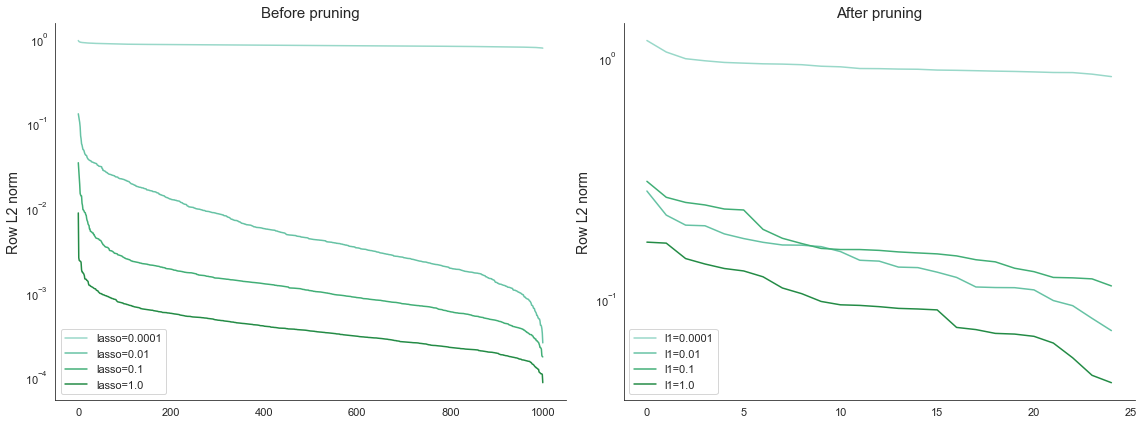

In [117]:
fig = plt.figure(figsize = (16, 6))
ax1 = fig.add_subplot(121)
colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']
for j, l1 in enumerate(l1_params):
    ax1.plot(range(1000), np.sort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[j, ::-1].T, \
             c = colours[j], label = 'lasso={}'.format(l1))
ax1.set_ylabel('Row L2 norm', fontsize = 14)
ax1.set_title('Before pruning', fontsize = 15)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.tick_params(axis='both', which='minor', labelsize=11)
ax1.set_yscale('log')
ax1.legend(loc='best', fontsize=11)

ax2 = fig.add_subplot(122)
for j, l1 in enumerate(l1_params):
    ax2.plot(range(25), np.sort(np.linalg.norm(weights_after_unfreezing_ap, ord=2, axis=2), axis = 1)[j, ::-1].T, \
             c = colours[j], label = 'l1={}'.format(l1))
ax2.set_ylabel('Row L2 norm', fontsize = 14)
ax2.set_title('After pruning', fontsize = 15)
ax2.tick_params(axis='both', which='major', labelsize=11)
ax2.tick_params(axis='both', which='minor', labelsize=11)
ax2.set_yscale('log')
ax2.legend(loc='best', fontsize=11)
sns.despine()
plt.tight_layout()

In [122]:
# This should be a pickled file created from the other notebook
with open('KerasSavedModels/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'rb') as f:
        r2_before_unfreezing, r2_before_unfreezing_tr, \
        r2_after_unfreezing, r2_after_unfreezing_tr, \
        r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
        r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

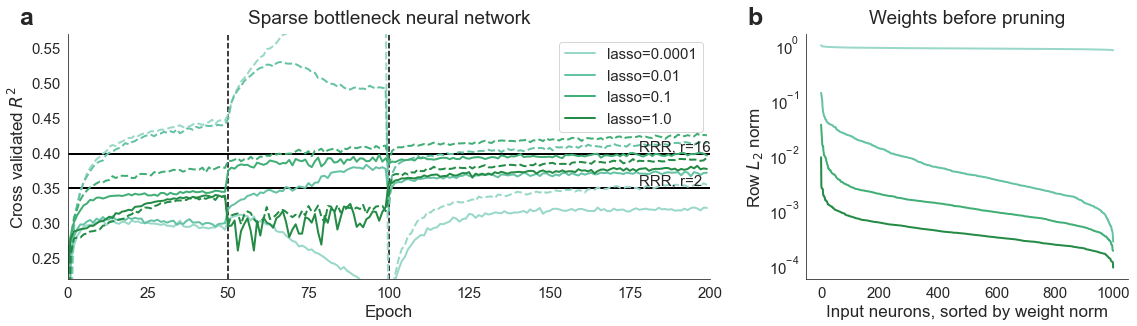

In [123]:
# Everything in one figure for the paper
linewidth = 2
epochs_used = 200
colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

fig = plt.figure(figsize=(19, 4.5))
widths = [2, 1]
heights = [1]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                          height_ratios=heights)

ax1 = fig.add_subplot(spec[0, 0])
for j, l1 in enumerate(l1_params):
    ax1.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis = (0, 2))[j, :].T, \
             '--', c = colours[j], linewidth=linewidth)
    ax1.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis = (0, 2))[j, :].T, \
             c = colours[j], linewidth=linewidth, label='lasso={}'.format(l1))
ax1.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax1.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax1.annotate('RRR, r=16', (178, r_rank16_r[np.isclose(n_rank16, 25, atol=3)]+0.004), fontsize=15)
ax1.annotate('RRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=3)]+0.004), fontsize=15)
ax1.set_ylim([0.22, 0.57])
ax1.set_xlim([0, epochs_used])
ax1.set_title('Sparse bottleneck neural network', fontsize = 19, y=1.02)
ax1.set_xlabel('Epoch', fontsize = 17)
ax1.set_ylabel(r'Cross validated $R^2$', fontsize = 17)
ax1.legend(loc='best', fontsize = 15)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.set_xticks(np.arange(0, 225, 25))
ax1.vlines(x=50, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')
ax1.vlines(x=100, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')

ax2 = fig.add_subplot(spec[0, 1])
colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']
for j, l1 in enumerate(l1_params):
    ax2.plot(range(1000), np.sort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[j, ::-1].T, \
             c = colours[j], label = 'lasso={}'.format(l1), linewidth=linewidth)
ax2.set_ylabel(r'Row $L_2$ norm', fontsize = 17)
ax2.set_xlabel('Input neurons, sorted by weight norm', fontsize = 17)
ax2.set_title('Weights before pruning', fontsize = 19, y=1.02)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.set_yscale('log')

plt.text(-0.075, 1.04, 'a', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.185, 1.04, 'b', transform = ax2.transAxes, fontsize=25, fontweight='bold')
sns.despine()

plt.savefig('figures/Lasso_training_curves_freeze_unfreeze_and_weights.png', bbox_inches = 'tight',
    pad_inches = 0)
plt.savefig('figures/Lasso_training_curves_freeze_unfreeze_and_weights.pdf', bbox_inches = 'tight',
    pad_inches = 0)

In [124]:
# Print the genes selected for this lasso, our favourite model 
highest_genes = 25
for j, l1 in enumerate(l1_params):
    print('For lasso: {}'.format(l1), \
          '\nThese {} highest genes were selected: '.format(highest_genes), \
         geneNames[np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[j, ::-1][:highest_genes]])

For lasso: 0.0001 
These 25 highest genes were selected:  ['Hpse' 'Vip' 'Sorbs2' 'Pak1' 'Crh' 'Bdnf' 'Elmo1' 'Zcchc18' 'Iqschfp'
 'Cct3' 'Sparcl1' 'Ctss' 'Ndst3' 'Icam1' 'Vwa5b1' 'Lrrn3' 'Ldha' 'Col6a1'
 'Prox1' 'Nptx1' 'Ptger3' 'Cdk16' 'Flii' 'Galnt14' 'Nefl']
For lasso: 0.01 
These 25 highest genes were selected:  ['Vip' 'Pvalb' 'Gad1' 'Sst' 'Synpr' 'Prox1' 'Fezf2' 'Calb1' 'Igf1' 'Tafa1'
 'Ptger3' 'Kcnab1' 'Sparcl1' 'Thsd7a' 'Adamts1' 'Reln' 'Gm11549' 'Rph3a'
 'Arpp19' 'Adcyap1' 'Zfp551' 'Gad2' 'Gm42616' 'Rasgrp1' 'Cnr1']
For lasso: 0.1 
These 25 highest genes were selected:  ['Sst' 'Vip' 'Pvalb' 'Gad1' 'Ndn' 'Gm49948' 'Lamp5' 'Tac2' 'Htr3a'
 'Sparcl1' 'Ndst3' 'Kcnip2' 'Plch2' 'Col24a1' 'Unc13c' 'Enpp2' 'Gabrd'
 'Galnt14' 'Kcnc2' 'Elfn1' 'Dlx6os1' 'Gm11549' 'Cacna1e' 'Phactr1'
 'Atp1a3']
For lasso: 1.0 
These 25 highest genes were selected:  ['Pvalb' 'Tac2' 'Sst' 'Gabrd' 'Gad1' 'Gm49948' 'Htr3a' 'Vip' 'Lamp5'
 'Cplx1' 'Tac1' 'Synpr' 'Gng4' 'Parm1' 'Galnt14' 'Ndst3' 'Pcp4l1'
 '6330403

# Visualization latent spaces

In [125]:
from tensorflow.keras import backend as K
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Text(0.5, 1.0, 'Latent space')

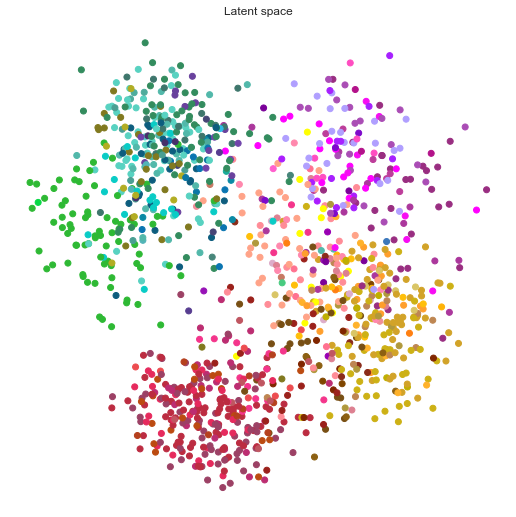

In [126]:
# Before unfreezing
cvfold_id=1000
lasso_id=2 # a number from 0 to 3 (corresponding to 1e-4, 1e-2, 1e-1, 1 lasso penalty respectively)
saved_model = load_model('KerasSavedModels/FreezeUnfreeze_before_unfreezing_full_dataset_{}_{}_{}.h5'.\
                        format(cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
#ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
#                                  [saved_model.output])
#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
latent = encoder.predict(X_no_low_qual)                 # bottleneck representation

sns.set_style('white')
plt.figure(figsize = (9, 9))
plt.scatter(latent[:, 0], latent[:, 1],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes])
sns.despine(bottom = True, left = True)
plt.xticks([])
plt.yticks([])
plt.title('Latent space')

Text(0.5, 1.0, 'Latent space')

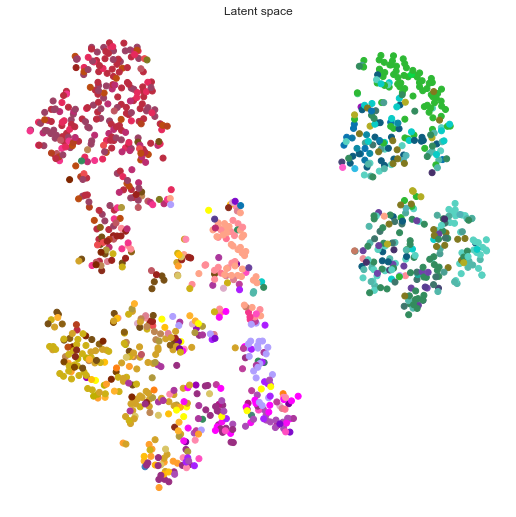

In [39]:
# Before unfreezing, higher dimensional bottleneck
lasso_id=2
cvfold_id=4000 # corresponding to a number in a file that relates to your higher dimensional bottleneck
saved_model = load_model('KerasSavedModels/FreezeUnfreeze_before_unfreezing_full_dataset_{}_{}_{}.h5'.\
                        format(cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
#ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
#                                  [saved_model.output])
#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]

latent = encoder.predict(X_no_low_qual)                 # bottleneck representation


# tSNE on 16 nodes bottleneck
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
PCinit = PCA(n_components=2).fit_transform(latent)
PCinit = PCinit / np.std(PCinit[:,0]) * 0.0001
Z = TSNE(init=PCinit, early_exaggeration=4).fit_transform(latent)


sns.set_style('white')
plt.figure(figsize = (9, 9))
plt.scatter(Z[:, 0], Z[:, 1],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes])
sns.despine(bottom = True, left = True)
plt.xticks([])
plt.yticks([])
plt.title('Latent space')

R^2 score on all:  0.45287150144577026


Text(0.5, 1.0, 'Latent space')

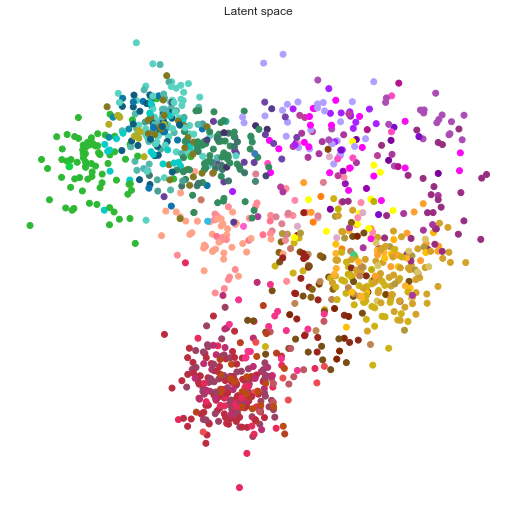

In [40]:
# After unfreezing
lasso_id=2
cvfold_id=1000
saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                        format(cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
#ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
#                                  [saved_model.output])

#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
latent = encoder.predict(X_no_low_qual)                 # bottleneck representation
ephys_prediction = saved_model.predict(X_no_low_qual)             # class prediction
print('R^2 score on all: ', 1-np.sum((Y_no_low_qual - saved_model.predict(x=X_no_low_qual))**2) / np.sum(Y_no_low_qual**2))

sns.set_style('white')
plt.figure(figsize = (9, 9))
plt.scatter(latent[:, 0], latent[:, 1],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes])
sns.despine(bottom = True, left = True)
plt.xticks([])
plt.yticks([])
plt.title('Latent space')

R^2 score on all:  0.4920433759689331


Text(0.5, 1.0, 'Latent space')

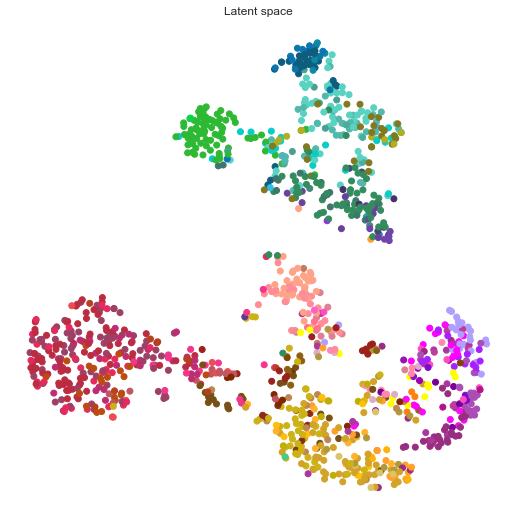

In [41]:
# After unfreezing, higher dimensional bottleneck
lasso_id=2
cvfold_id=4000
saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                        format(cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
                                  [saved_model.output])
#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
latent = encoder.predict(X_no_low_qual)                 # bottleneck representation
ephys_prediction = saved_model.predict(X_no_low_qual)             # class prediction
print('R^2 score on all: ', 1-np.sum((Y_no_low_qual - saved_model.predict(x=X_no_low_qual))**2) / np.sum(Y_no_low_qual**2))

# tSNE on 16 nodes bottleneck
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
PCinit = PCA(n_components=2).fit_transform(latent)
PCinit = PCinit / np.std(PCinit[:,0]) * 0.0001
Z = TSNE(init=PCinit, early_exaggeration=4).fit_transform(latent)

sns.set_style('white')
plt.figure(figsize = (9, 9))
plt.scatter(Z[:, 0], Z[:, 1],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes])
sns.despine(bottom = True, left = True)
plt.xticks([])
plt.yticks([])
plt.title('Latent space')

R^2 score on all:  0.4370890259742737


Text(0.5, 1.0, 'Latent space')

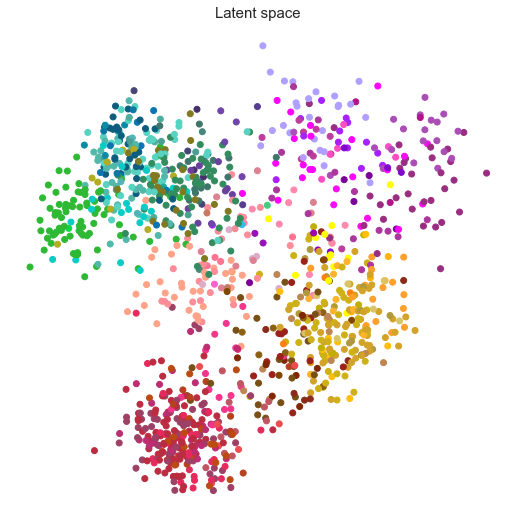

In [127]:
# After pruning
lasso_id=2
cvfold_id=1000
saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format(cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
                                  [saved_model.output])
#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
latent = encoder.predict(X_no_low_qual[:, ind_genes])                 # bottleneck representation
ephys_prediction = saved_model.predict(X_no_low_qual[:, ind_genes])             # class prediction
print('R^2 score on all: ', 1-np.sum((Y_no_low_qual - \
                                      saved_model.predict(x=X_no_low_qual[:, ind_genes]))**2) / np.sum(Y_no_low_qual**2))

sns.set_style('white')
plt.figure(figsize = (9, 9))
plt.scatter(latent[:, 0], latent[:, 1],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes])
sns.despine(bottom = True, left = True)
plt.xticks([])
plt.yticks([])
plt.title('Latent space', fontsize=15)

R^2 score on all:  -0.0017056465148925781


Text(0.5, 1.0, 'Latent space')

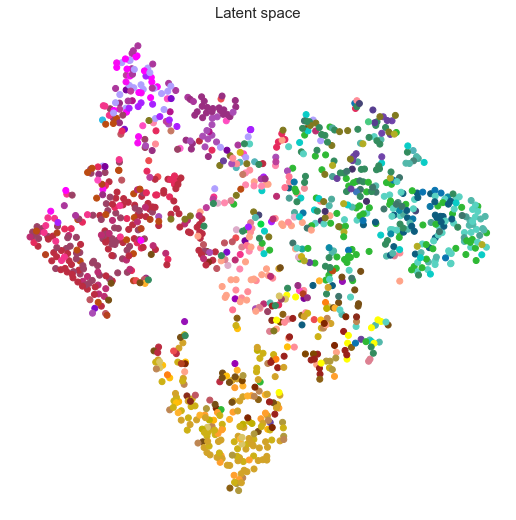

In [43]:
# After pruning, higher dimensional bottleneck
lasso_id=2
cvfold_id=4000
saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format(cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
                                  [saved_model.output])
#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
latent = encoder.predict(X_no_low_qual[:, ind_genes])                 # bottleneck representation
ephys_prediction = saved_model.predict(X_no_low_qual[:, ind_genes])             # class prediction
print('R^2 score on all: ', 1-np.sum((Y_no_low_qual - \
                                      saved_model.predict(x=X_no_low_qual[:, ind_genes]))**2) / np.sum(Y_no_low_qual**2))

# tSNE on 16 nodes bottleneck
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
PCinit = PCA(n_components=2).fit_transform(latent)
PCinit = PCinit / np.std(PCinit[:,0]) * 0.0001
Z = TSNE(init=PCinit, early_exaggeration=4).fit_transform(latent)

sns.set_style('white')
plt.figure(figsize = (9, 9))
plt.scatter(Z[:, 0], Z[:, 1],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes])
sns.despine(bottom = True, left = True)
plt.xticks([])
plt.yticks([])
plt.title('Latent space', fontsize=15)

In [128]:
def latent_space_ephys(model, X, Y, Y_column_index, features, celltypes, cellTypeLabels, \
                       cellTypeColors, alpha = 1, axis = None):
    '''
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    Y: 2D numpy array, normalized ephys data
    Y_column_index: column index in Y, correspoding to certain feature
    features: list of all ephys features (Y_column_index should correspond to correct feature in this list!)
    celltypes: 1D numpy array, same size as first dimension of X and Y, numbers denote celltype/cellclass
    celltypeLabels: dictionary with celltype numbers corresponding to celltype names
    celltypeColors: dictionary with celltype names corresponding to celltype colours
    alpha: transparancy for contours (default = 0.5)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure objects; latent space with gene activation contours
    '''
    # Create mappings from the model to get latent activations from genes and ephys predictions from genes and
    # latent activations
    encoder = Model(model.input, model.get_layer('bottleneck').output)
    latent = encoder.predict(X)
    ephys_prediction = saved_model.predict(X)

    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    ax.tricontourf(latent[:, 0], latent[:, 1], ephys_prediction[:, Y_column_index])
    ax.set_xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
    ax.set_ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(features[Y_column_index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [129]:
# For higher dimensional bottlenecks
def latent_space_ephys_tSNE(model, Z, X, Y_column_index, features, celltypes, cellTypeLabels, \
                       cellTypeColors, alpha = 1, axis = None):
    '''
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    Z: tSNE projection from bottleneck
    X: 2D numpy array, normalized transcriptomic data
    Y_column_index: column index in Y, correspoding to certain feature
    features: list of all ephys features (Y_column_index should correspond to correct feature in this list!)
    celltypes: 1D numpy array, same size as first dimension of X and Y, numbers denote celltype/cellclass
    celltypeLabels: dictionary with celltype numbers corresponding to celltype names
    celltypeColors: dictionary with celltype names corresponding to celltype colours
    alpha: transparancy for contours (default = 0.5)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure objects; latent space with gene activation contours
    '''
    
    ephys_prediction = saved_model.predict(X)
  
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    
    ax.tricontourf(Z[:, 0], Z[:, 1], ephys_prediction[:, Y_column_index])
    ax.set_xlim([np.min(Z[:, 0]), np.max(Z[:, 0])])
    ax.set_ylim([np.min(Z[:, 1]), np.max(Z[:, 1])])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(features[Y_column_index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

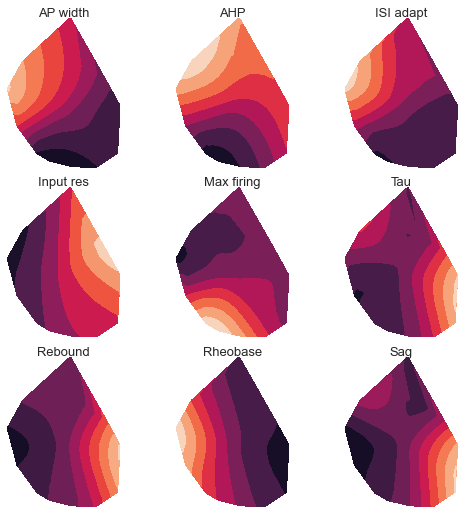

In [130]:
lasso_id=2
cvfold_id=1000
fig = plt.figure(figsize=(9, 9))
widths = [1,1,1]
heights = [1,1,1]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights)

saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format(cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[1, :][-25:]
features = ['AP amp', 'AP amp adapt', 'AP amp CV', 'AP thresh', 'AP width', 'AHP', \
            'ISI adapt', 'ISI CV', 'Input res', 'Max firing', 'Tau', \
            'Rebound', r'$V_m$', 'Rheobase', 'Sag', 'UDR']
spec.update(wspace=0.025, hspace=0.13)

# Use the index of the feature that you want to see as input integer in the latent_space function
ax1 = fig.add_subplot(spec[0, 0])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        4, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax1)
ax2 = fig.add_subplot(spec[0, 1])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        5, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax2)
ax3 = fig.add_subplot(spec[0, 2])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        6, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax3)
ax4 = fig.add_subplot(spec[1, 0])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        8, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax4)
ax5 = fig.add_subplot(spec[1, 1])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        9, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax5)
ax6 = fig.add_subplot(spec[1, 2])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        10, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax6)
ax7 = fig.add_subplot(spec[2, 0])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        11, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax7)
ax8 = fig.add_subplot(spec[2, 1])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        13, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax8)
ax9 = fig.add_subplot(spec[2, 2])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        14, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax9)
sns.despine(bottom=True, left=True)

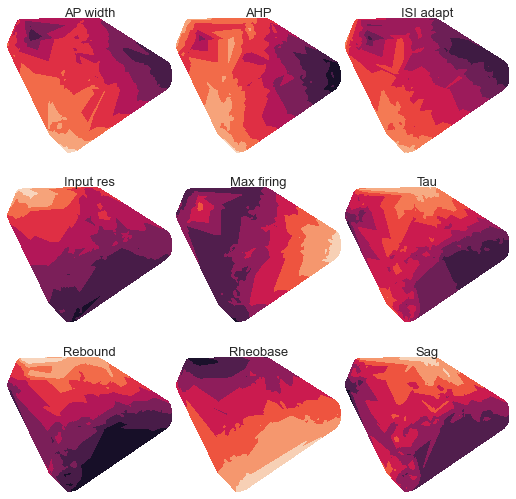

In [124]:
#!! Make sure you've loaded the correct weigts_after_unfreezing

lasso_id=2
cvfold_id=16000
fig = plt.figure(figsize=(9, 9))
widths = [1,1,1]
heights = [1,1,1]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights)

saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format(cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
                                  [saved_model.output])
#!! Make sure you've loaded the correct weigts_after_unfreezing
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
latent = encoder.predict(X_no_low_qual[:, ind_genes])                 # bottleneck representation


PCinit = PCA(n_components=2).fit_transform(latent)
PCinit = PCinit / np.std(PCinit[:,0]) * 0.0001
Z = TSNE(init=PCinit, early_exaggeration=4).fit_transform(latent)

features = ['AP amp', 'AP amp adapt', 'AP amp CV', 'AP thresh', 'AP width', 'AHP', \
            'ISI adapt', 'ISI CV', 'Input res', 'Max firing', 'Tau', \
            'Rebound', r'$V_m$', 'Rheobase', 'Sag', 'UDR']
spec.update(wspace=0.025, hspace=0.13)

# Use the index of the feature that you want to see as input integer in the latent_space function
ax1 = fig.add_subplot(spec[0, 0])
latent_space_ephys_tSNE(saved_model, Z, X_no_low_qual[:, ind_genes], \
        4, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax1)
ax2 = fig.add_subplot(spec[0, 1])
latent_space_ephys_tSNE(saved_model, Z, X_no_low_qual[:, ind_genes], \
        5, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax2)
ax3 = fig.add_subplot(spec[0, 2])
latent_space_ephys_tSNE(saved_model, Z, X_no_low_qual[:, ind_genes], \
        6, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax3)
ax4 = fig.add_subplot(spec[1, 0])
latent_space_ephys_tSNE(saved_model, Z, X_no_low_qual[:, ind_genes], \
        8, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax4)
ax5 = fig.add_subplot(spec[1, 1])
latent_space_ephys_tSNE(saved_model, Z, X_no_low_qual[:, ind_genes], \
        9, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax5)
ax6 = fig.add_subplot(spec[1, 2])
latent_space_ephys_tSNE(saved_model, Z, X_no_low_qual[:, ind_genes], \
        10, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax6)
ax7 = fig.add_subplot(spec[2, 0])
latent_space_ephys_tSNE(saved_model, Z, X_no_low_qual[:, ind_genes], \
        11, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax7)
ax8 = fig.add_subplot(spec[2, 1])
latent_space_ephys_tSNE(saved_model, Z, X_no_low_qual[:, ind_genes], \
        13, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax8)
ax9 = fig.add_subplot(spec[2, 2])
latent_space_ephys_tSNE(saved_model, Z, X_no_low_qual[:, ind_genes], \
        14, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax9)
sns.despine(bottom=True, left=True)

In [131]:
def latent_space_genes(model, latent, X, X_column_index, geneNames, celltypes, cellTypeLabels, \
                       cellTypeColors, alpha = 1, axis = None):
    '''
    Parameters
    ----------
    model: keras decoder network (from latent space to selected genes)
    latent: bottleneck activations
    X: 2D numpy array, normalized transcriptomic data (should be a selected genes i.e. reduced size matrix)
    X_column_index: column index in X, correspoding to certain gene
    geneNames: list of gene names (X_column_index should correspond to correct gene in this list!)
    celltypes: 1D numpy array, same size as first dimension of X and Y, numbers denote celltype/cellclass
    celltypeLabels: dictionary with celltype numbers corresponding to celltype names
    celltypeColors: dictionary with celltype names corresponding to celltype colours
    alpha: transparancy for contours (default = 0.5)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure objects; latent space with gene activation contours
    '''
    gene_prediction=model.predict(latent)
    
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    
    ax.tricontourf(latent[:, 0], latent[:, 1], gene_prediction[:, X_column_index])
    ax.set_xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
    ax.set_ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(geneNames[X_column_index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [132]:
# For higher dimensional bottlenecks
def latent_space_genes_tSNE(model, latent, Z, X_column_index, geneNames, celltypes, cellTypeLabels, \
                       cellTypeColors, alpha = 1, axis = None):
    '''
    Parameters
    ----------
    model: keras decoder network (from latent space to selected genes)
    latent: bottleneck activations
    Z: tSNE dimensional latent reduction
    X_column_index: column index in X, correspoding to certain gene
    geneNames: list of gene names (X_column_index should correspond to correct gene in this list!)
    celltypes: 1D numpy array, same size as first dimension of X and Y, numbers denote celltype/cellclass
    celltypeLabels: dictionary with celltype numbers corresponding to celltype names
    celltypeColors: dictionary with celltype names corresponding to celltype colours
    alpha: transparancy for contours (default = 0.5)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure objects; latent space with gene activation contours
    '''

    gene_prediction=model.predict(latent)
    
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    
    ax.tricontourf(Z[:, 0], Z[:, 1], gene_prediction[:, X_column_index])
    ax.set_xlim([np.min(Z[:, 0]), np.max(Z[:, 0])])
    ax.set_ylim([np.min(Z[:, 1]), np.max(Z[:, 1])])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(geneNames[X_column_index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Text(-0.09, 1.04, 'c')

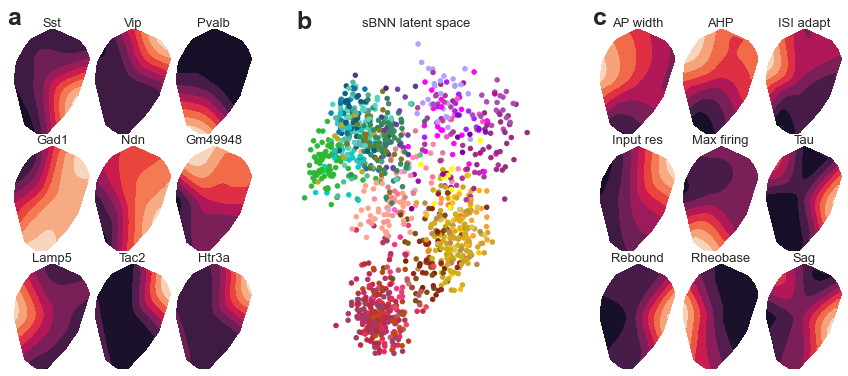

In [139]:
#!! Make sure you've loaded the correct weigts_after_unfreezing

# All in one, for the paper
lasso_id=2
cvfold_id=1000
fig = plt.figure(figsize=(16, 5.2))
widths = [1,1,1,2.4]
heights = [1,1,1]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths,
                          height_ratios=heights)
spec.update(wspace=0, hspace=0.125)

saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format(cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
latent = encoder.predict(X_no_low_qual[:, ind_genes])                 # bottleneck representation

saved_model_AE = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_AE_{}_{}_{}.h5'.\
                        format(cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Cell types
ax9 = fig.add_subplot(spec[:, 3])
ax9.scatter(latent[:, 0], latent[:, 1],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes], s=20)
ax9.set_aspect('equal', adjustable='box')
ax9.set_title('sBNN latent space', fontsize=13, y=0.99)
ax9.set_xticks([])
ax9.set_yticks([])

# genes
ax0 = fig.add_subplot(spec[0, 0])
latent_space_genes(saved_model_AE, latent, X_no_low_qual[:, ind_genes], 
        -1, geneNames[ind_genes], cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax0)
ax1 = fig.add_subplot(spec[0, 1])
latent_space_genes(saved_model_AE, latent, X_no_low_qual[:, ind_genes],\
        -2, geneNames[ind_genes], cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax1)
ax2 = fig.add_subplot(spec[0, 2])
latent_space_genes(saved_model_AE, latent, X_no_low_qual[:, ind_genes], \
        -3, geneNames[ind_genes], cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax2)
ax3 = fig.add_subplot(spec[1, 0])
latent_space_genes(saved_model_AE, latent, X_no_low_qual[:, ind_genes],  \
        -4, geneNames[ind_genes], cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax3)
ax4= fig.add_subplot(spec[1, 1])
latent_space_genes(saved_model_AE, latent, X_no_low_qual[:, ind_genes], \
        -5, geneNames[ind_genes], cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax4)
ax5 = fig.add_subplot(spec[1, 2])
latent_space_genes(saved_model_AE, latent, X_no_low_qual[:, ind_genes], \
        -6, geneNames[ind_genes], cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax5)
ax6 = fig.add_subplot(spec[2, 0])
latent_space_genes(saved_model_AE, latent, X_no_low_qual[:, ind_genes], \
        -7, geneNames[ind_genes], cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax6)
ax7 = fig.add_subplot(spec[2, 1])
latent_space_genes(saved_model_AE, latent, X_no_low_qual[:, ind_genes], \
        -8, geneNames[ind_genes], cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax7)
ax8 = fig.add_subplot(spec[2, 2])
latent_space_genes(saved_model_AE, latent, X_no_low_qual[:, ind_genes], \
        -9, geneNames[ind_genes], cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax8)


spec.tight_layout(fig, rect=[0, 0, 0.59, 1], h_pad=0)


# ephys
features = ['AP amp', 'AP amp adapt', 'AP amp CV', 'AP thresh', 'AP width', 'AHP', \
            'ISI adapt', 'ISI CV', 'Input res', 'Max firing', 'Tau', \
            'Rebound', r'$V_m$', 'Rheobase', 'Sag', 'UDR']
widths = [1,1,1]
heights = [1,1,1]
spec2 = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights)
spec2.update(wspace=0, hspace=0.125)


ax10 = fig.add_subplot(spec2[0, 0])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        4, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax10)
ax11 = fig.add_subplot(spec2[0, 1])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        5, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax11)
ax12 = fig.add_subplot(spec2[0, 2])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        6, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax12)
ax13 = fig.add_subplot(spec2[1, 0])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        8, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax13)
ax14 = fig.add_subplot(spec2[1, 1])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        9, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax14)
ax15 = fig.add_subplot(spec2[1, 2])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        10, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax15)
ax16 = fig.add_subplot(spec2[2, 0])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        11, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax16)
ax17 = fig.add_subplot(spec2[2, 1])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        13, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax17)
ax18 = fig.add_subplot(spec2[2, 2])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        14, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax18)
spec2.tight_layout(fig, rect=[0.45, 0, 0.88, 1], h_pad=0)
sns.despine(bottom=True, left=True)
plt.text(+0.01, 1.00, 'b', transform = ax9.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.09, 1.04, 'a', transform = ax0.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.09, 1.04, 'c', transform = ax10.transAxes, fontsize=25, fontweight='bold')
plt.savefig('figures/Bottleneck_latent_space_all_together.png', bbox_inches = 'tight',
     pad_inches = 0)
plt.savefig('figures/Bottleneck_latent_space_all_together.pdf', bbox_inches = 'tight',
    pad_inches = 0)

In [141]:
cvfold_id=4000
weights_after_unfreezing = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format(cvfold_id, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing.append(saved_model.get_weights()[0])
weights_after_unfreezing = np.array(weights_after_unfreezing)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Text(-0.09, 1.04, 'c')

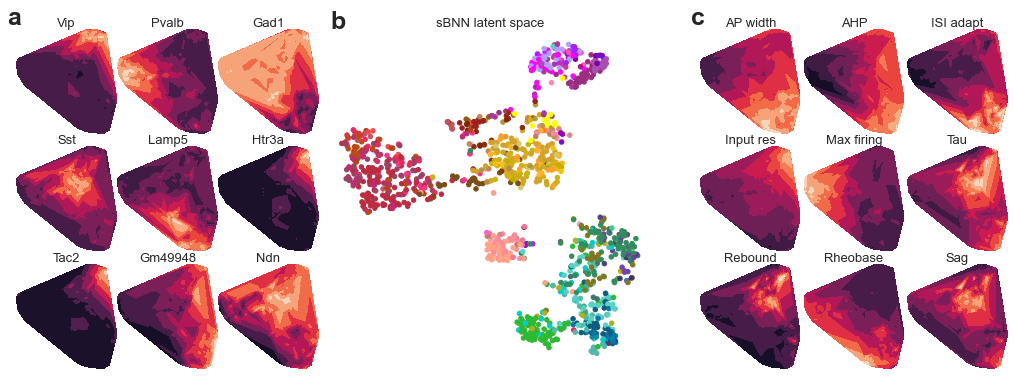

In [143]:
#!! Make sure you've loaded the correct weigts_after_unfreezing

# All in one, tSNE on bottleneck!, for the paper
lasso_id=2
cvfold_id=4000
fig = plt.figure(figsize=(16, 5.2))
widths = [1,1,1,2.4]
heights = [1,1,1]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths,
                          height_ratios=heights)
spec.update(wspace=0, hspace=0.12)

saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format(cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
latent = encoder.predict(X_no_low_qual[:, ind_genes])                 # bottleneck representation

PCinit = PCA(n_components=2).fit_transform(latent)
PCinit = PCinit / np.std(PCinit[:,0]) * 0.0001
Z = TSNE(init=PCinit, early_exaggeration=4).fit_transform(latent)

saved_model_AE = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_AE_{}_{}_{}.h5'.\
                        format(cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Cell types
ax9 = fig.add_subplot(spec[:, 3])
ax9.scatter(Z[:, 0], Z[:, 1],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes], s=20)
ax9.set_aspect('equal', adjustable='box')
ax9.set_title('sBNN latent space', fontsize=13, y=0.99)
ax9.set_xticks([])
ax9.set_yticks([])

# genes
ax0 = fig.add_subplot(spec[0, 0])
latent_space_genes_tSNE(saved_model_AE, latent, Z, \
        -1, geneNames[ind_genes], cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax0)
ax1 = fig.add_subplot(spec[0, 1])
latent_space_genes_tSNE(saved_model_AE, latent, Z, \
        -2, geneNames[ind_genes], cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax1)
ax2 = fig.add_subplot(spec[0, 2])
latent_space_genes_tSNE(saved_model_AE, latent, Z, \
        -3, geneNames[ind_genes], cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax2)
ax3 = fig.add_subplot(spec[1, 0])
latent_space_genes_tSNE(saved_model_AE, latent, Z, \
        -4, geneNames[ind_genes], cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax3)
ax4= fig.add_subplot(spec[1, 1])
latent_space_genes_tSNE(saved_model_AE, latent, Z, \
        -5, geneNames[ind_genes], cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax4)
ax5 = fig.add_subplot(spec[1, 2])
latent_space_genes_tSNE(saved_model_AE, latent, Z, \
        -6, geneNames[ind_genes], cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax5)
ax6 = fig.add_subplot(spec[2, 0])
latent_space_genes_tSNE(saved_model_AE, latent, Z, \
        -7, geneNames[ind_genes], cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax6)
ax7 = fig.add_subplot(spec[2, 1])
latent_space_genes_tSNE(saved_model_AE, latent, Z, \
        -8, geneNames[ind_genes], cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax7)
ax8 = fig.add_subplot(spec[2, 2])
latent_space_genes_tSNE(saved_model_AE, latent, Z, \
        -9, geneNames[ind_genes], cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax8)


spec.tight_layout(fig, rect=[0, 0, 0.64, 1], h_pad=0)


# ephys
features = ['AP amp', 'AP amp adapt', 'AP amp CV', 'AP thresh', 'AP width', 'AHP', \
            'ISI adapt', 'ISI CV', 'Input res', 'Max firing', 'Tau', \
            'Rebound', r'$V_m$', 'Rheobase', 'Sag', 'UDR']
widths = [1,1,1]
heights = [1,1,1]
spec2 = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights)
spec2.update(wspace=0, hspace=0.12)

ax10 = fig.add_subplot(spec2[0, 0])
latent_space_ephys_tSNE(saved_model, Z, X_no_low_qual[:, ind_genes], \
        4, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax10)
ax11 = fig.add_subplot(spec2[0, 1])
latent_space_ephys_tSNE(saved_model, Z, X_no_low_qual[:, ind_genes], \
        5, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax11)
ax12 = fig.add_subplot(spec2[0, 2])
latent_space_ephys_tSNE(saved_model, Z, X_no_low_qual[:, ind_genes], \
        6, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax12)
ax13 = fig.add_subplot(spec2[1, 0])
latent_space_ephys_tSNE(saved_model, Z, X_no_low_qual[:, ind_genes], \
        8, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax13)
ax14 = fig.add_subplot(spec2[1, 1])
latent_space_ephys_tSNE(saved_model, Z, X_no_low_qual[:, ind_genes], \
        9, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax14)
ax15 = fig.add_subplot(spec2[1, 2])
latent_space_ephys_tSNE(saved_model, Z, X_no_low_qual[:, ind_genes], \
        10, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax15)
ax16 = fig.add_subplot(spec2[2, 0])
latent_space_ephys_tSNE(saved_model, Z, X_no_low_qual[:, ind_genes], \
        11, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax16)
ax17 = fig.add_subplot(spec2[2, 1])
latent_space_ephys_tSNE(saved_model, Z, X_no_low_qual[:, ind_genes], \
        13, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax17)
ax18 = fig.add_subplot(spec2[2, 2])
latent_space_ephys_tSNE(saved_model, Z, X_no_low_qual[:, ind_genes], \
        14, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax18)

spec2.tight_layout(fig, rect=[0.535, 0, 1, 1], h_pad=0)
sns.despine(bottom=True, left=True)
plt.text(+0.01, 1.00, 'b', transform = ax9.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.09, 1.04, 'a', transform = ax0.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.09, 1.04, 'c', transform = ax10.transAxes, fontsize=25, fontweight='bold')
plt.savefig('figures/Bottleneck_latent_space_all_together_4nodes_bottleneck.png', bbox_inches = 'tight',
     pad_inches = 0)
plt.savefig('figures/Bottleneck_latent_space_all_together_4nodes_bottleneck.pdf', bbox_inches = 'tight',
    pad_inches = 0)

In [144]:
# And what are the genes selected for sRRR for the different cross validated sets and the lambdau we'd have to pick?

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

t = time.time()
n = X_no_low_qual.shape[0]
X = np.copy(X_no_low_qual)
Y = np.copy(Y_no_low_qual)

X = X.astype('float64')
Y = Y.astype('float64')

vx_rank2, vy_rank2 = sparseRRR.elastic_rrr(X, Y, \
                            lambdau=lambdas[np.isclose(n_rank2, 25, atol=3)], alpha=1, rank=2, sparsity='row-wise')
print('For rank 2, ', \
      '\nThese highest genes were selected: ', \
      geneNames[np.sum(vx_rank2, axis = 1)!=0])
vx_rank16, vy_rank16 = sparseRRR.elastic_rrr(X, Y, \
                            lambdau=lambdas[np.isclose(n_rank16, 25, atol=3)], alpha=1, rank=16, sparsity='row-wise')

print('For rank 16, ', \
      '\nThese highest genes were selected: ', \
      geneNames[np.sum(vx_rank16, axis = 1)!=0])

For rank 2,  
These highest genes were selected:  ['Arpp21' 'Bcan' 'Bdnf' 'Cacna1e' 'Cacna2d1' 'Coro6' 'Elfn1' 'Erbb4'
 'Gabrd' 'Gad1' 'Galnt14' 'Htr3a' 'Kcnip2' 'Kcnv1' 'Lamp5' 'Mybpc1'
 'Npas1' 'Nxph1' 'Plch2' 'Ptk2b' 'Pvalb' 'Slc6a1' 'Sst' 'Synpr' 'Tac1']
For rank 16,  
These highest genes were selected:  ['Arpp21' 'Bcan' 'Bdnf' 'Cacna1e' 'Cacna2d1' 'Coro6' 'Elfn1' 'Erbb4'
 'Gabrd' 'Gad1' 'Htr3a' 'Lamp5' 'Mybpc1' 'Nxph1' 'Plch2' 'Ptk2b' 'Pvalb'
 'Slc6a1' 'Sst' 'Synpr' 'Tac1' 'Tafa1' 'Vip']


In [145]:
def latent_space_ephys_sRRR(X, vx, vy, Y_column_index, features, celltypes, cellTypeLabels, \
                       cellTypeColors, alpha = 1, axis = None):

    '''
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    vx: matrix to (linearly) project to botteneck
    vy: matrix to (linearly) project from bottleneck to ephys space
    Y_column_index: column index in Y, correspoding to certain feature
    features: list of all ephys features (Y_column_index should correspond to correct feature in this list!)
    celltypes: 1D numpy array, same size as first dimension of X and Y, numbers denote celltype/cellclass
    celltypeLabels: dictionary with celltype numbers corresponding to celltype names
    celltypeColors: dictionary with celltype names corresponding to celltype colours
    alpha: transparancy for contours (default = 0.5)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure object, latent space with ephys activation contours
    '''
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    
    ax.tricontourf((X@vx)[:, 1], (X@vx)[:, 0], (X@vx@vy.T)[:, Y_column_index])
    ax.set_xlim([np.min((X@vx)[:, 1]), np.max((X@vx)[:, 1])])
    ax.set_ylim([np.min((X@vx)[:, 0]), np.max((X@vx)[:, 0])])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(features[Y_column_index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [146]:
def latent_space_genes_sRRR(X, vx, index, geneNames, celltypes, cellTypeLabels, \
                       cellTypeColors, alpha = 0.5, axis = None):
    ''' 
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    vx: matrix to (linearly) project to botteneck
    vy: matrix to (linearly) project from bottleneck to ephys space
    index: index in the 25 genes selected for the gene that you'd like to show
    geneNames: list of gene names (X_column_index should correspond to correct gene in this list!)
    celltypes: 1D numpy array, same size as first dimension of X and Y, numbers denote celltype/cellclass
    celltypeLabels: dictionary with celltype numbers corresponding to celltype names
    celltypeColors: dictionary with celltype names corresponding to celltype colours
    alpha: transparancy for contours (default = 0.5)
    ax: axis to plot one (default: None)
    
    Returns
    -------
    axis: figure objects; latent space with gene activation contours
    '''
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))

    ax.tricontourf((X@vx)[:,1], (X@vx)[:,0], X@vx@np.linalg.pinv(vx)[:, np.sum(vx, axis = 1)!=0][:, index])
    ax.set_xlim([np.min((X@vx)[:, 1]), np.max((X@vx)[:, 1])])
    ax.set_ylim([np.min((X@vx)[:, 0]), np.max((X@vx)[:, 0])])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(geneNames[np.sum(vx, axis = 1)!=0][index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Text(-0.6, 1.04, 'f')

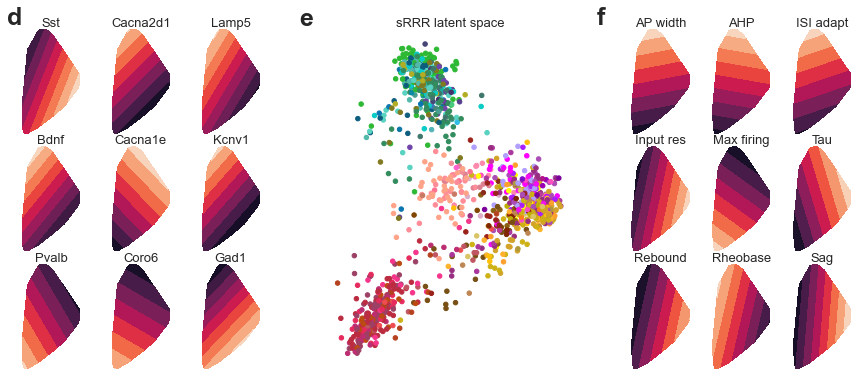

In [147]:
# All in one, for the paper
fig = plt.figure(figsize=(16, 5.2))
widths = [1,1,1,3]
heights = [1,1,1]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths,
                          height_ratios=heights)
spec.update(wspace=0, hspace=0.12)

# suppressing "mean of empty slice" warnings
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore", category=RuntimeWarning)
#     n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
#     r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
#     n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
#     r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

    
vx_rank2, vy_rank2 = sparseRRR.elastic_rrr(X, Y, \
                            lambdau=0.40, alpha=1, rank=2, sparsity='row-wise')    
    
# Cell types
ax9 = fig.add_subplot(spec[:, 3])
ax9.scatter((X@vx_rank2)[:, 1], (X@vx_rank2)[:, 0],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes], s=20)
#ax0.set_aspect('equal', adjustable='box')
ax9.set_title('sRRR latent space', fontsize=13, y=0.99)
ax9.set_xlim([-2.5, 2.5])
ax9.set_xticks([])
ax9.set_yticks([])

# genes
ax0 = fig.add_subplot(spec[0, 0])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        22, geneNames, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax0)
ax1 = fig.add_subplot(spec[0, 1])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        4, geneNames, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax1)
ax2 = fig.add_subplot(spec[0, 2])
latent_space_genes_sRRR(X_no_low_qual,  vx_rank2, \
        14, geneNames, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax2)
ax3 = fig.add_subplot(spec[1, 0])
latent_space_genes_sRRR(X_no_low_qual,   vx_rank2, \
        2, geneNames, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax3)
ax4= fig.add_subplot(spec[1, 1])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        3, geneNames, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax4)
ax5 = fig.add_subplot(spec[1, 2])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        13, geneNames, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax5)
ax6 = fig.add_subplot(spec[2, 0])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        20, geneNames, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax6)
ax7 = fig.add_subplot(spec[2, 1])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        5, geneNames, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax7)
ax8 = fig.add_subplot(spec[2, 2])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        9, geneNames, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax8)


spec.tight_layout(fig, rect=[0, 0, 0.59, 1], h_pad=0)

# ephys
features = ['AP amp', 'AP amp adapt', 'AP amp CV', 'AP thresh', 'AP width', 'AHP', \
            'ISI adapt', 'ISI CV', 'Input res', 'Max firing', 'Tau', \
            'Rebound', r'$V_m$', 'Rheobase', 'Sag', 'UDR']
widths = [1,1,1]
heights = [1,1,1]
spec2 = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights)
spec2.update(wspace=0, hspace=0.12)
ax10 = fig.add_subplot(spec2[0, 0])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        4, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax10)
ax11 = fig.add_subplot(spec2[0, 1])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        5, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax11)
ax12 = fig.add_subplot(spec2[0, 2])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        6, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax12)
ax13 = fig.add_subplot(spec2[1, 0])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        8, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax13)
ax14 = fig.add_subplot(spec2[1, 1])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        9, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax14)
ax15 = fig.add_subplot(spec2[1, 2])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        10, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax15)
ax16 = fig.add_subplot(spec2[2, 0])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        11, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax16)
ax17 = fig.add_subplot(spec2[2, 1])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        13, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax17)
ax18 = fig.add_subplot(spec2[2, 2])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        14, features, cellTypes, cellTypeLabels, \
        cellTypeColors, axis=ax18)
spec2.tight_layout(fig, rect=[0.45, 0, 0.88, 1], h_pad=0)
sns.despine(bottom=True, left=True)

plt.text(+0.11, 1.01, 'e', transform = ax9.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.25, 1.04, 'd', transform = ax0.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.6, 1.04, 'f', transform = ax10.transAxes, fontsize=25, fontweight='bold')
plt.savefig('figures/Bottleneck_latent_space_all_together_sRRR.png', bbox_inches = 'tight',
    pad_inches = 0)
plt.savefig('figures/Bottleneck_latent_space_all_together_sRRR.pdf', bbox_inches = 'tight',
    pad_inches = 0)